In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
import xgboost as xgb
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [3]:
df=pd.read_csv('/content/train.csv')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [6]:
df['Date']=pd.to_datetime(df['Date'])

In [8]:
print(df['Date'].dtype)

datetime64[ns]


In [10]:
df.describe()

,Store,Dept,Date,Weekly_Sales
count,421570.000000,421570.000000,421570,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000
std,12.785297,30.492054,NaN,22711.183519


In [12]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['dow'] = df['Date'].dt.dayofweek
df['is_weekend'] = df['dow'].isin([5,6]).astype(int)

In [14]:
for lag in [1,7,28]:
    df[f'lag_{lag}'] = df.groupby('Store')['Weekly_Sales'].shift(lag)


keep_cols = [f'lag_{l}' for l in [1,7,28]] + ['Weekly_Sales']
df_model = df.dropna(subset=keep_cols).copy()


split_date = df_model['Date'].quantile(0.8)
train = df_model[df_model['Date'] <= split_date].copy()
valid = df_model[df_model['Date'] > split_date].copy()

features = ['year','month','day','dow','is_weekend','lag_1','lag_7','lag_28']
X_train = train[features].fillna(0)
y_train = train['Weekly_Sales']
X_val = valid[features].fillna(0)
y_val = valid['Weekly_Sales']

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(337478, 8)
(337478,)
(82832, 8)
(82832,)


In [45]:
rf=RandomForestRegressor(n_estimators=50,max_depth=12,random_state=42, n_jobs=1)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=12, n_estimators=50, n_jobs=1, random_state=42)

In [46]:
rf.score(X_train,y_train)

0.9655336449445134

In [47]:
rf.score(X_val,y_val)

0.9772780431899001

In [48]:
y_pred=rf.predict(X_val)
print(y_pred)

[33129.89061703 17218.04433866 18205.7507337  ...   653.54017765
  1087.52005927   809.65355967]


In [49]:
print(y_val)
print(y_pred)

115       16976.19
116       16347.60
117       17147.44
118       18164.20
119       18517.79
            ...   
421565      508.37
421566      628.10
421567     1061.02
421568      760.01
421569     1076.80
Name: Weekly_Sales, Length: 82832, dtype: float64
[33129.89061703 17218.04433866 18205.7507337  ...   653.54017765
  1087.52005927   809.65355967]


In [50]:
print(mean_squared_error(y_val,y_pred))
print(mean_absolute_error(y_val,y_pred))
print(mean_absolute_percentage_error(y_val,y_pred))
print(r2_score(y_val,y_pred))

10964729.581141591
1506.7397807563157
59213731088784.7
0.9772780431899001


In [51]:
out = valid[['Date','Store','Dept','Weekly_Sales']].copy()
out['pred'] = y_pred

In [52]:
print(out)

             Date  Store  Dept  Weekly_Sales          pred
115    2012-04-20      1     1      16976.19  33129.890617
116    2012-04-27      1     1      16347.60  17218.044339
117    2012-05-04      1     1      17147.44  18205.750734
118    2012-05-11      1     1      18164.20  17598.266856
119    2012-05-18      1     1      18517.79  18378.769017
...           ...    ...   ...           ...           ...
421565 2012-09-28     45    98        508.37    568.100284
421566 2012-10-05     45    98        628.10    519.280845
421567 2012-10-12     45    98       1061.02    653.540178
421568 2012-10-19     45    98        760.01   1087.520059
421569 2012-10-26     45    98       1076.80    809.653560

[82832 rows x 5 columns]


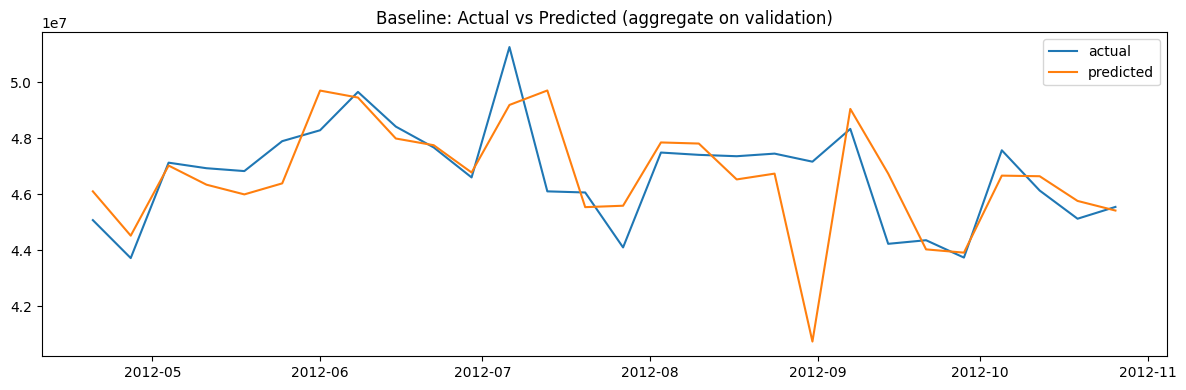

In [27]:
agg_true = out.groupby('Date')['Weekly_Sales'].sum()
agg_pred = out.groupby('Date')['pred'].sum()
plt.figure(figsize=(12,4))
plt.plot(agg_true.index, agg_true.values, label='actual')
plt.plot(agg_pred.index, agg_pred.values, label='predicted')
plt.legend(); plt.title('Baseline: Actual vs Predicted (aggregate on validation)')
plt.tight_layout()

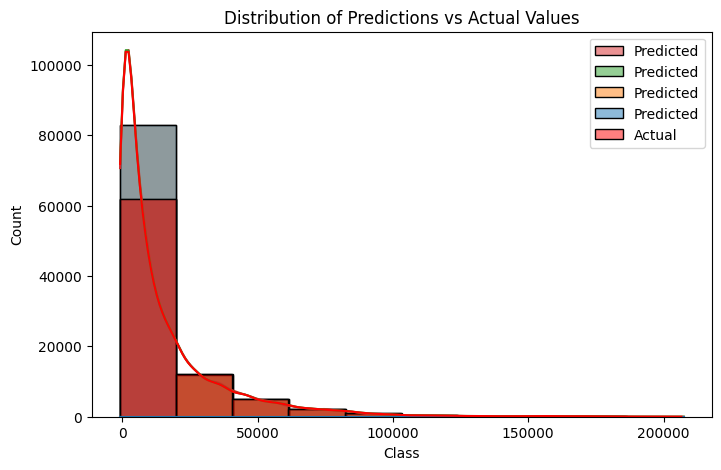

In [29]:
plt.figure(figsize=(8, 5))
sns.histplot(out, color='blue', label="Predicted", alpha=0.5, bins=10, kde=True)
sns.histplot(y_val, color='red', label="Actual", alpha=0.5, bins=10, kde=True)

plt.legend()
plt.title("Distribution of Predictions vs Actual Values")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [30]:
print(rf.feature_importances_)

[0.0014993  0.00780445 0.0212976  0.         0.         0.9389994
 0.0199163  0.01048296]


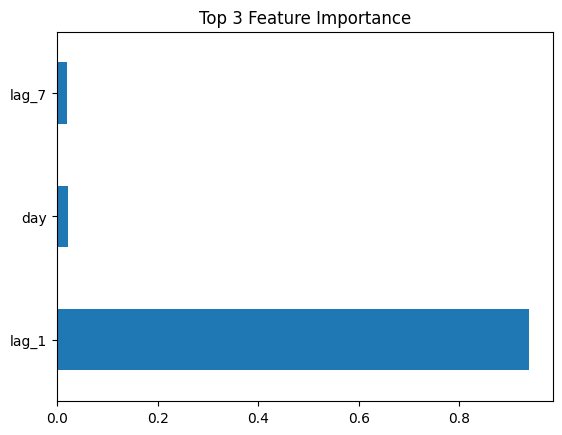

In [31]:
feature_importance = pd.Series(rf.feature_importances_, index=features)
feature_importance.nlargest(3).plot(kind='barh')
plt.title("Top 3 Feature Importance")
plt.show()

In [32]:
knn=KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train,y_train)

KNeighborsRegressor()

In [33]:
knn.score(X_train,y_train)

0.9300405750600718

In [34]:
knn.score(X_val,y_val)

0.962561445608911

In [35]:
y_pred=knn.predict(X_val)
print(y_pred)

[27636.292 17754.174 16725.778 ...   597.576  1062.014   930.208]


In [36]:
print(y_val)
print(y_pred)

115       16976.19
116       16347.60
117       17147.44
118       18164.20
119       18517.79
            ...   
421565      508.37
421566      628.10
421567     1061.02
421568      760.01
421569     1076.80
Name: Weekly_Sales, Length: 82832, dtype: float64
[27636.292 17754.174 16725.778 ...   597.576  1062.014   930.208]


In [37]:
print(mean_squared_error(y_val,y_pred))
print(mean_absolute_error(y_val,y_pred))
print(mean_absolute_percentage_error(y_val,y_pred))
print(r2_score(y_val,y_pred))

18066385.225443386
1912.77075096581
937411496293779.1
0.962561445608911


In [38]:
out = valid[['Date','Store','Dept','Weekly_Sales']].copy()
out['pred'] = y_pred

In [39]:
print(out)

             Date  Store  Dept  Weekly_Sales       pred
115    2012-04-20      1     1      16976.19  27636.292
116    2012-04-27      1     1      16347.60  17754.174
117    2012-05-04      1     1      17147.44  16725.778
118    2012-05-11      1     1      18164.20  19331.062
119    2012-05-18      1     1      18517.79  21156.228
...           ...    ...   ...           ...        ...
421565 2012-09-28     45    98        508.37    485.018
421566 2012-10-05     45    98        628.10    639.406
421567 2012-10-12     45    98       1061.02    597.576
421568 2012-10-19     45    98        760.01   1062.014
421569 2012-10-26     45    98       1076.80    930.208

[82832 rows x 5 columns]


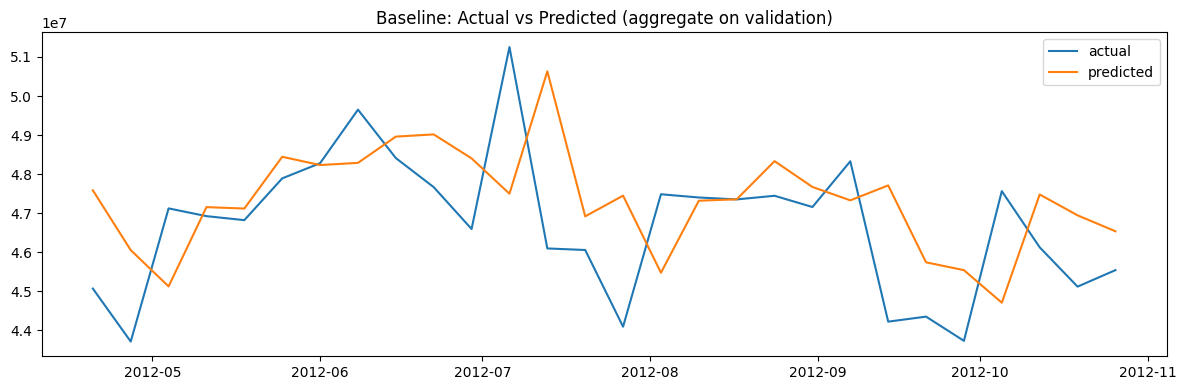

In [40]:
agg_true = out.groupby('Date')['Weekly_Sales'].sum()
agg_pred = out.groupby('Date')['pred'].sum()
plt.figure(figsize=(12,4))
plt.plot(agg_true.index, agg_true.values, label='actual')
plt.plot(agg_pred.index, agg_pred.values, label='predicted')
plt.legend(); plt.title('Baseline: Actual vs Predicted (aggregate on validation)')
plt.tight_layout()

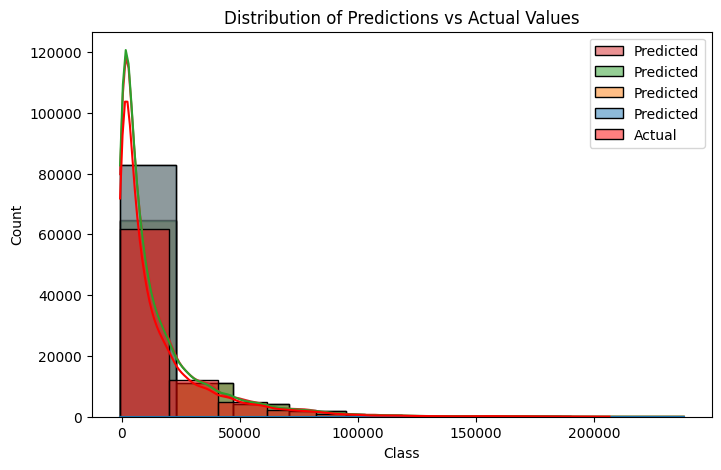

In [41]:
plt.figure(figsize=(8, 5))
sns.histplot(out, color='blue', label="Predicted", alpha=0.5, bins=10, kde=True)
sns.histplot(y_val, color='red', label="Actual", alpha=0.5, bins=10, kde=True)

plt.legend()
plt.title("Distribution of Predictions vs Actual Values")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#Bonus


In [53]:
df['roll_mean_7'] = df.groupby('Store')['Weekly_Sales'].shift(1).rolling(7).mean().reset_index(level=0, drop=True)
df['roll_mean_30'] = df.groupby('Store')['Weekly_Sales'].shift(1).rolling(30).mean().reset_index(level=0, drop=True)
df['ewm_14'] = df.groupby('Store')['Weekly_Sales'].apply(lambda x: x.shift(1).ewm(span=14).mean()).reset_index(level=0, drop=True)

In [54]:
for lag in [1,7,28]:
    df[f'lag_{lag}'] = df.groupby('Store')['Weekly_Sales'].shift(lag)

In [60]:
ts = df.groupby('Date')['Weekly_Sales'].sum()
seasonal = np.zeros(len(df))
try:
    res = seasonal_decompose(ts, model='additive', period=52, extrapolate_trend='freq')
    seasonal_map = res.seasonal.reindex(df['Date']).values
    seasonal = seasonal_map
except Exception as e:
    print("seasonal_decompose warning:", e)
df['global_seasonal'] = seasonal

In [61]:
features = ['year','month','day','dow','is_weekend','lag_1','lag_7','lag_28','roll_mean_7','roll_mean_30','ewm_14','global_seasonal']
df_model = df.dropna(subset=features + ['Weekly_Sales']).copy()
print("Advanced usable rows:", df_model.shape[0])

Advanced usable rows: 420220


In [62]:
X = df_model[features]
y = df_model['Weekly_Sales']
tscv = TimeSeriesSplit(n_splits=4)

In [63]:
print(X.shape)
print(y.shape)

(420220, 12)
(420220,)


In [64]:
use_xgb = True
try:
    import xgboost as xgb
except Exception as e:
    use_xgb = False
    print("xgboost not found - will use LightGBM. Error:", e)

In [65]:
all_preds = []
all_trues = []
fold_results = []
idx_list = []

In [72]:
for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    if use_xgb:
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        params = {'objective':'reg:squarederror','eval_metric':'rmse','eta':0.05,'max_depth':6,'subsample':0.8,'colsample_bytree':0.8,'seed':42}
        bst = xgb.train(params, dtrain, num_boost_round=800, evals=[(dtrain,'train'),(dval,'val')], early_stopping_rounds=30, verbose_eval=50)
        pred = bst.predict(dval)
    else:
        lgb_train = lgb.Dataset(X_train, label=y_train)
        lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)
        params = {'objective':'regression','metric':'rmse','learning_rate':0.05,'num_leaves':31,'verbosity':-1,'seed':42}
        bst = lgb.train(params, lgb_train, num_boost_round=800, valid_sets=[lgb_val], early_stopping_rounds=30, verbose_eval=50)
        pred = bst.predict(X_val, num_iteration=bst.best_iteration)


    rmse = mean_squared_error(y_val, pred)
    mae = mean_absolute_error(y_val, pred)
    fold_results.append({'fold': fold, 'rmse': rmse, 'mae': mae, 'n_val': len(val_idx)})
    print(f"Fold {fold}: RMSE={rmse:.4f}, MAE={mae:.4f}, val_rows={len(val_idx)}")
    all_preds.extend(pred.tolist())
    all_trues.extend(y_val.tolist())
    idx_list.extend(val_idx.tolist())

[0]	train-rmse:23321.48860	val-rmse:24418.78753
[50]	train-rmse:4924.13323	val-rmse:7088.99072
[100]	train-rmse:4037.38606	val-rmse:6491.89306
[150]	train-rmse:3797.12215	val-rmse:6423.31647
[200]	train-rmse:3629.68035	val-rmse:6387.31098
[250]	train-rmse:3505.75839	val-rmse:6368.23227
[300]	train-rmse:3390.04317	val-rmse:6350.96398
[329]	train-rmse:3322.80838	val-rmse:6352.67456
Fold 0: RMSE=40356473.9456, MAE=2102.5604, val_rows=84044
[0]	train-rmse:23851.26752	val-rmse:21499.08454
[50]	train-rmse:5737.79525	val-rmse:6027.04343
[100]	train-rmse:4950.35342	val-rmse:5641.15303
[150]	train-rmse:4660.76278	val-rmse:5560.28062
[200]	train-rmse:4464.87246	val-rmse:5540.61305
[240]	train-rmse:4342.58013	val-rmse:5545.94726
Fold 1: RMSE=30753463.9902, MAE=2045.8141, val_rows=84044
[0]	train-rmse:23094.42718	val-rmse:20213.81177
[50]	train-rmse:5808.58089	val-rmse:5234.41040
[100]	train-rmse:5072.54441	val-rmse:4804.26786
[150]	train-rmse:4808.79854	val-rmse:4703.73973
[200]	train-rmse:4624.7

In [73]:
avg_rmse = np.mean([r['rmse'] for r in fold_results])
avg_mae = np.mean([r['mae'] for r in fold_results])
print("Advanced average RMSE", avg_rmse, "MAE", avg_mae)

preds_df = pd.DataFrame({'idx': idx_list, 'actual': all_trues, 'predicted': all_preds})
preds_df = preds_df.sort_values('idx').reset_index(drop=True)

Advanced average RMSE 27410281.076378956 MAE 1784.7448195849397


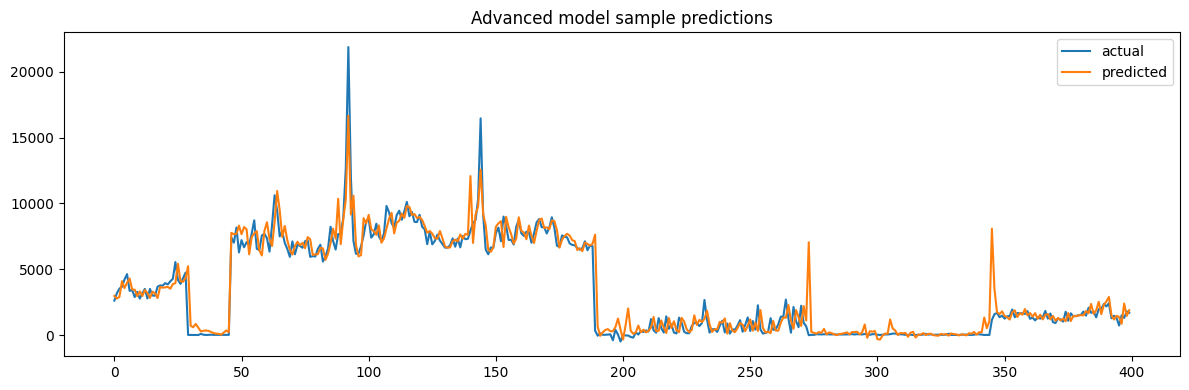

In [74]:
plt.figure(figsize=(12,4))
n_plot = min(400, len(preds_df))
plt.plot(preds_df['actual'].values[:n_plot], label='actual')
plt.plot(preds_df['predicted'].values[:n_plot], label='predicted')
plt.legend(); plt.title('Advanced model sample predictions')
plt.tight_layout()